In [1]:
import torch
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

In [4]:
T = 1
M = 1500
n_sim = 1000
dt = T/M
u = 1.05
d = 1.0/u
spot = 50.0
strike = 70.0
rate = 0.01

prob = (np.exp(rate*dt) - d)/(u-d) 

t = torch.linspace(0,1,M)

# Binomial Tree method

In [5]:
import numpy as np

from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r args:[%r, %r] took: %2.4f sec' % \
          (f.__name__, args, kw, te-ts))
        return result
    return wrap

In [6]:
def BinomialTree(S: float,  # S_0
                 K : float, # K
                 r : float, # r
                 u : float, # up
                 T : float,  # maturity
                 M : float):   # step 
    d = 1/u # down            
    # computing constants
    dt = T/M # delta 
    prob = (np.exp(r*dt) - d)/(u - d) # risk-neutral probability
    disc  = np.exp( - r*dt)
        
    C = S * d ** (torch.arange(M,-1,-1)) * u ** (torch.arange(0, M+1, 1))
    C = torch.max( C - K , torch.zeros(M+1) )

    for i in range(M,0,-1):
        C = disc * ( prob * C[1:i+1] + (1 - prob) * C[0:i] )

    return C[0]
        

In [7]:
sigma_bs = np.log(u)/np.sqrt(1.0/M)
normal = torch.distributions.Normal(0,1)
N = normal.cdf
logNp = normal.log_prob

In [10]:
forward_bs = torch.Tensor([spot])
strike_bs = torch.Tensor([strike])
sigma = torch.Tensor([sigma_bs])
maturity  = t
time_t = torch.Tensor([0.0])

dt = maturity - time_t
d1 = (torch.log(forward_bs / strike) + sigma**2*dt/2) / (sigma*torch.sqrt(dt))
d2 = d1 - sigma*torch.sqrt(dt)
fv = (forward_bs*N(d1) - strike*N(d2))*torch.exp(-rate*torch.ones_like(t))

In [11]:
bin_fw = [BinomialTree(50.0, 70.0 , 0.01, 1.05, 1.0, x) for x in range(1, M + 1)]

In [12]:
df = pd.DataFrame({'bs': np.array(fv), 'bin': np.array(bin_fw)}).iloc[200:]


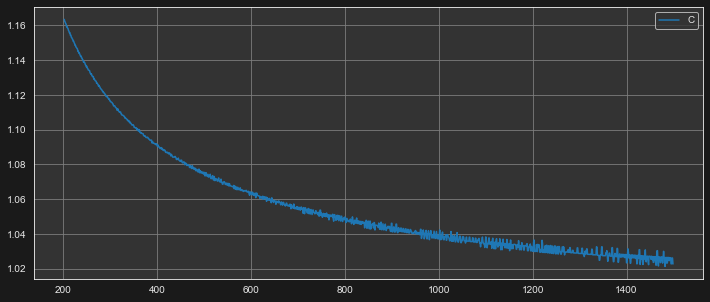

In [23]:
((df.bin - df.bs)/(df.bin.shift() - df.bs)).abs().rolling(window=2).mean().plot(figsize=(12,5))
plt.legend("Convergence rate")
plt.show()

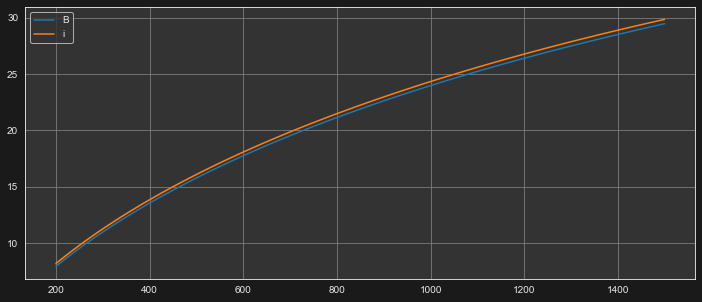

In [14]:
df.plot(figsize=(12,5))
plt.legend("Binomial Tree and Black-Scholes Comparison")
plt.show()

## Delta-hedging

## American Option

In [72]:
def AmericanOptionDP(S0: float,  # S_0
                     K : float, # K
                     r : float, # r
                     u : float, # up
                     T : float,  # maturity
                     M : float,
                     opttype='C'):
    #precompute values
    dt = T/M
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)
    
    # initialise stock prices at maturity
    S = S0 * d**(np.arange(M,-1,-1)) * u**(np.arange(0,M+1,1))
        
    # option payoff 
    if opttype == 'P':
        C = np.maximum(0, K - S)
    else:
        C = np.maximum(0, S - K)
    
    # backward recursion through the tree
    for i in np.arange(M-1,-1,-1):
        S = S0 * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
        C[:i+1] = disc * ( q*C[1:i+2] + (1-q)*C[0:i+1] )
        C = C[:-1]
        if opttype == 'P':
            C = np.maximum(C, K - S)
        else:
            C = np.maximum(C, S - K)
                
    return C[0]


In [75]:
american_fw = [AmericanOptionDP(37, 35.0 , 0.01, 1.05, 1.0, x) for x in [3,50, 100, 250 ,500 ,1000, 2500, 5000, 7500 ,10000]]

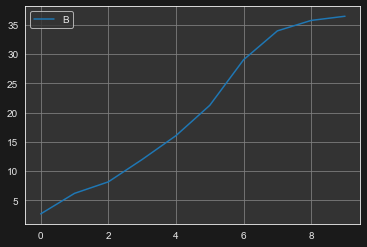

In [76]:
plt.plot(american_fw)
plt.legend("Binomial Tree American Option")
plt.show()